# APIs

In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import root_mean_squared_error

# %pip install pypalettes
import pypalettes
from pypalettes import load_cmap

import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning)

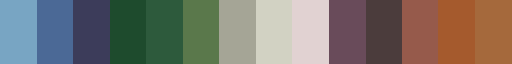

In [68]:
cmap = load_cmap('fleurs_dans_un_vase_de_cristal')
cmap

In [69]:
print(cmap.colors[4])

#2D5A3CFF


# Setup data

## Load train data

In [70]:
train_csv = pd.read_csv('data/train.csv')

In [71]:
train_csv.shape

(7478, 33)

Drop rows with all null values, and extreme outliers

In [72]:
train_csv.iloc[[175, 913, 7067, 508, 5789], :]

,Id,Scraped_Time,Condition,Car Make,Model,Trim,Year,Kilometers,Body Type,Number of Seats,...,Neighborhood,Category,Subcategory,Interior Options,Exterior Options,Technology Options,Description_Score,Battery Capacity,Battery Range,Price
175,176,2025-02-07 12:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Khalda,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1750.0
913,914,2025-02-07 12:52:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Russayfah,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,2000.0
7067,7068,2025-02-07 13:20:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Al Hay Al Sharqy,Cars and Bikes,Cars For Sale,NaN,NaN,NaN,NaN,NaN,NaN,1250.0
508,509,2025-02-07 00:50:31,Used,Chevrolet,Cruze,Standard,2010,"80,000 - 89,999",Sedan,5,...,Tla' Ali,Cars and Bikes,Cars For Sale,"AUX / USB Input, Steering Wheel Controls, Elec...","Spare Tyre, Electric Mirrors","Android Auto, Bluetooth, Touch Screen, Media S...",NaN,NaN,NaN,1000000.0
5789,5790,2025-02-06 21:19:43,Used,Toyota,Hiace,Cargo,1991,"130,000 - 139,999",Bus - Van,9,...,Dayr Yusuf,Cars and Bikes,Cars For Sale,Airbags,Back Hook,Navigation system / maps,NaN,NaN,NaN,999999.0


In [73]:
train_csv.drop(index=[175, 913, 7067, 508, 5789], inplace=True)

In [74]:
train_csv.shape

(7473, 33)

## Update Column Names

In [75]:
cols_map = {'Id': 'id', 'Scraped_Time': 'scraped_time', 'Condition': 'condition', 
            'Car Make': 'car_make', 'Model': 'model', 'Trim': 'trim', 'Year': 'year', 
            'Kilometers': 'kilometers', 'Body Type': 'body_type', 'Number of Seats': 'num_of_seats', 
            'Fuel': 'fuel', 'Transmission': 'transmission', 'Engine Size (cc)': 'engine_size_cc', 
            'Exterior Color': 'exterior_color', 'Interior Color': 'interior_color', 
            'Regional Specs': 'regional_specs', 'Car License': 'car_license', 'Insurance': 'insurance', 
            'Car Customs': 'car_customs', 'Body Condition': 'body_condition', 'Paint': 'paint', 
            'Payment Method': 'payment_method', 'City': 'city', 'Neighborhood': 'neighborhood', 
            'Category': 'category', 'Subcategory': 'subcategory', 'Interior Options': 'interior_options', 
            'Exterior Options': 'exterior_options', 'Technology Options': 'technology_options', 
            'Description_Score': 'description_score', 'Battery Capacity': 'battery_capacity', 
            'Battery Range': 'battery_range', 'Price': 'price'}

In [76]:
train_csv.rename(columns=cols_map, inplace=True)
train_csv.columns

Index(['id', 'scraped_time', 'condition', 'car_make', 'model', 'trim', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission',
       'engine_size_cc', 'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city', 'neighborhood', 'category', 'subcategory',
       'interior_options', 'exterior_options', 'technology_options',
       'description_score', 'battery_capacity', 'battery_range', 'price'],
      dtype='object')

## Splitting Train data into Training and Test sets

In [77]:
target = 'price'
y = train_csv[target]
X = train_csv.drop(columns=target)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True)

In [78]:
print(X_train.shape, y_train.shape,'\n', X_test.shape, y_test.shape)

(5604, 32) (5604,) 
 (1869, 32) (1869,)


# Baseline Model

## Preprocessor

In [79]:
drop_features = ['id', 'scraped_time', 'category', 'subcategory', 'description_score']
options_features = ['interior_options', 'exterior_options', 'technology_options']
cat_features_imp_zero = ['trim', 'engine_size_cc', 'battery_capacity', 'battery_range', 'neighborhood']
cat_features_imp_freq = ['condition', 'car_make', 'model', 'year',
       'kilometers', 'body_type', 'num_of_seats', 'fuel', 'transmission', 
       'exterior_color', 'interior_color', 'regional_specs',
       'car_license', 'insurance', 'car_customs', 'body_condition', 'paint',
       'payment_method', 'city']

In [80]:
len(drop_features + options_features + cat_features_imp_freq + cat_features_imp_zero)

32

In [81]:
cat_impute_freq_pipeline = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='most_frequent')),
    ('freq_to_str', FunctionTransformer(lambda x: x.astype(str))),
    ('freq_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [82]:
cat_impute_zero_pipeline = Pipeline(steps=[
    ('zero_imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('zero_to_str', FunctionTransformer(lambda x: x.astype(str))),
    ('zero_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [83]:
preprocessor = ColumnTransformer(transformers=[
    ('cat_impute_freq', cat_impute_freq_pipeline, cat_features_imp_freq),
    ('cat_impute_zero', cat_impute_zero_pipeline, cat_features_imp_zero),
    ('drop', 'drop', drop_features),
    ('options', 'drop', options_features)
], remainder='passthrough')

In [84]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [85]:
X_train_transformed.shape

(5604, 1664)

In [86]:
diff = set(X_test['car_make']).difference(set(X_train['car_make']))
diff

{'Lancia', 'Mahindra', 'Pontiac'}

In [87]:
Lancia_test = X_test[X_test['car_make']=='Lancia']
Lancia_test

,id,scraped_time,condition,car_make,model,trim,year,kilometers,body_type,num_of_seats,...,city,neighborhood,category,subcategory,interior_options,exterior_options,technology_options,description_score,battery_capacity,battery_range
6640,6641,2025-02-07 12:08:17,Used,Lancia,Lancia,NaN,2001,"40,000 - 49,999",Sedan,4,...,Irbid,Al Sareeh,Cars and Bikes,Cars For Sale,"Electric Windows, Center Lock, Heated Seats, A...","Daytime Running Lights, Spare Tyre",Bluetooth,NaN,NaN,NaN


In [88]:
Lancia_test_transformed = preprocessor.transform(Lancia_test)
Lancia_test_transformed.shape

(1, 1664)

In [89]:
Lancia_test_transformed

array([[0., 1., 0., ..., 0., 0., 0.]])

## Random Forest

Since the target 'price' is heavily right skewed, I am applying log transformation on it while training.

In [147]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfregressor', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

In [148]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [149]:
score = root_mean_squared_error(y_test, y_pred)
print(f'RMSE score for the RF model is {score:.2f}')

RMSE score for the RF model is 9335.83


In [92]:
rf_cv = cross_val_score(rf_model, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5)
rf_cv

array([ -9149.62113045,  -8828.45465381, -11854.43041577,  -8909.51289583,
        -7937.72946723])

In [93]:
rf_cv.mean()

-9335.949712616144

## Understanding the model

In [150]:
train_rmse = root_mean_squared_error(y_train, rf_model.predict(X_train))
test_rmse = root_mean_squared_error(y_test, rf_model.predict(X_test))

print(f'Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}')

Train RMSE: 4710.135, Test RMSE: 9335.826


Model is overfitting.

## Hyperparameter Tuning

### Grid Search CV

In [168]:
# param_grid = {
#     'rfregressor__regressor__n_estimators': [100, 500],
#     'rfregressor__regressor__max_depth': [10, 20],
#     'rfregressor__regressor__min_samples_split': [2, 5]
# }

# rf_grid = GridSearchCV(
#     rf_model,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1,
#     verbose=1
# )
# rf_grid.fit(X_train, y_train)

# print(f'Best params: {rf_grid.best_params_}')
# print(f'Best RMSE: {-rf_grid.best_score_:.2f}')
# Best params: {'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__min_samples_split': 5, 'rfregressor__regressor__n_estimators': 100}
# Best RMSE: 9323.25

### Randomized Search CV

In [157]:
param_dist = {
    'rfregressor__regressor__n_estimators': randint(100, 500),
    'rfregressor__regressor__max_depth': [10, 20, None],
    'rfregressor__regressor__min_samples_split': randint(2, 10),
    'rfregressor__regressor__min_samples_leaf': randint(1, 10),
    'rfregressor__regressor__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7]
}

rdmsearch = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

rdmsearch.fit(X_train, y_train)
print(f'Best params: {rdmsearch.best_params_}')

Best params: {'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__max_features': 0.7, 'rfregressor__regressor__min_samples_leaf': 2, 'rfregressor__regressor__min_samples_split': 9, 'rfregressor__regressor__n_estimators': 393}


Check train and test performance for above best_estimator_

In [159]:
train_rmse = root_mean_squared_error(y_train, rdmsearch.best_estimator_.predict(X_train))
test_rmse = root_mean_squared_error(y_test, rdmsearch.best_estimator_.predict(X_test))

print(f'Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}')

Train RMSE: 6714.123, Test RMSE: 9351.946


The model still seems overfitted (high variance).

In [167]:
results = pd.DataFrame(rdmsearch.cv_results_)
np.array(results[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False).head(5))

array([[{'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__max_features': 0.7, 'rfregressor__regressor__min_samples_leaf': 2, 'rfregressor__regressor__min_samples_split': 9, 'rfregressor__regressor__n_estimators': 393},
        -9459.645957649716],
       [{'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__max_features': 0.3, 'rfregressor__regressor__min_samples_leaf': 1, 'rfregressor__regressor__min_samples_split': 5, 'rfregressor__regressor__n_estimators': 149},
        -9517.811180751005],
       [{'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__max_features': 0.7, 'rfregressor__regressor__min_samples_leaf': 3, 'rfregressor__regressor__min_samples_split': 5, 'rfregressor__regressor__n_estimators': 351},
        -9528.333638059177],
       [{'rfregressor__regressor__max_depth': None, 'rfregressor__regressor__max_features': 0.3, 'rfregressor__regressor__min_samples_leaf': 1, 'rfregressor__regressor__min_samples_split': 9, 'rfregr

### Tuning Manually

In [179]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rfregressor', TransformedTargetRegressor(
        regressor=RandomForestRegressor(random_state=42,
                                        max_depth=None, 
                                        max_features=0.9, 
                                        min_samples_leaf=4,  
                                        n_estimators=300),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

rf_model.fit(X_train, y_train)

train_rmse = root_mean_squared_error(y_train, rf_model.predict(X_train))
test_rmse = root_mean_squared_error(y_test, rf_model.predict(X_test))
print(f'Train RMSE: {train_rmse:.3f}, Test RMSE: {test_rmse:.3f}')

Train RMSE: 7577.656, Test RMSE: 9523.991


## Function - Get Feature Names from Preprocessor

In [ ]:
def get_feature_names(preprocessor):
    output_features = []

    for name, trf, cols in preprocessor.transformers_:
        if trf == 'drop':
            continue
        elif trf == 'passthrough':
            output_features.extend(cols)
        else:
            if hasattr(trf, 'named_steps'):
                last_step = trf.named_steps[list(trf.named_steps)[-1]]
            else:
                last_step = trf
        
        if hasattr(last_step, 'get_feature_names_out'):
            transformed_names = last_step.get_feature_names_out(cols)
        else:
            transformed_names = cols
        
        output_features.extend(transformed_names)
    
    return output_features

## Important Features

In [118]:
rf_regressor = rf_grid.best_estimator_.named_steps['rfregressor'].regressor_

In [119]:
feature_imp = rf_regressor.feature_importances_
sorted_idx = np.argsort(feature_imp)[::-1]
sorted_idx

array([ 636,  631,  635, ...,  538, 1198,  744], dtype=int64)

In [123]:
transformed_feature_names = get_feature_names(rf_grid.best_estimator_.named_steps['preprocessor'])
np.array(transformed_feature_names[::20])

array(['condition_New', 'car_make_GAC', 'car_make_Leapmotor',
       'car_make_Skoda', 'model_207', 'model_7 Series', 'model_Atto 3',
       'model_Box', 'model_CTS/Catera', 'model_Cherokee',
       'model_Crown Victoria', 'model_EQ', 'model_Escalade',
       'model_Fortuner', 'model_Grand i10', 'model_ID 3', 'model_Kicks',
       'model_Logan', 'model_Menlo', 'model_Okavango', 'model_Pregio',
       'model_Range Rover Evoque', 'model_SM5', 'model_Skyworth',
       'model_T03', 'model_UX', 'model_XLR', 'year_1977', 'year_1997',
       'year_2017', 'kilometers_150,000 - 159,999', 'num_of_seats_2',
       'exterior_color_Blue', 'interior_color_Baby Blue',
       'interior_color_Turquoise',
       'body_condition_Poor (severe body damages)', 'city_Tafila',
       'trim_1LS', 'trim_523', 'trim_Adenture', 'trim_Bora',
       'trim_CLK 200', 'trim_Coupe', 'trim_E 350e', 'trim_ESV SR',
       'trim_G 500', 'trim_GLS Plus', 'trim_GXR', 'trim_ID.7 VIZZION Pro',
       'trim_LTZ', 'trim_Linear',

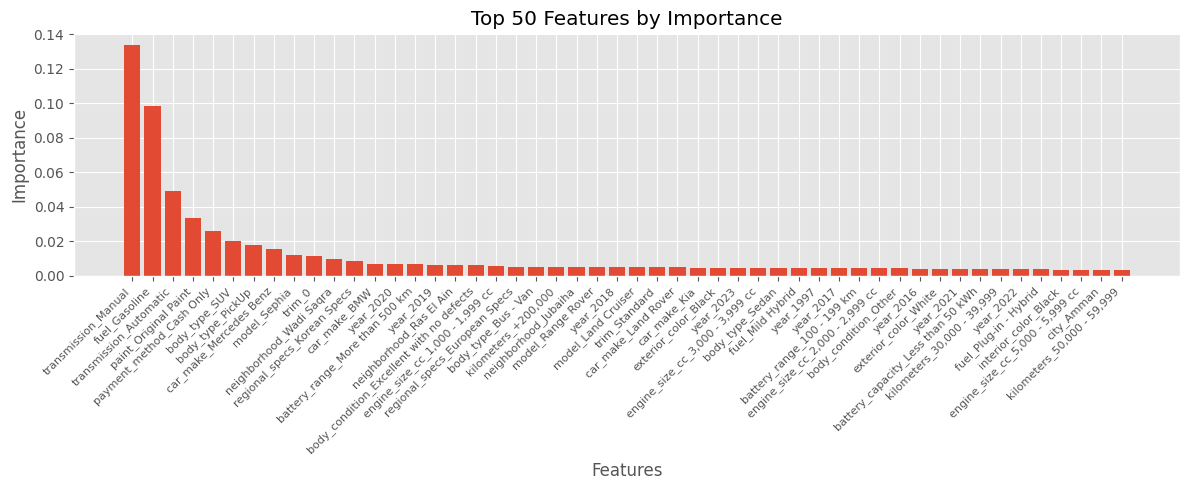

In [140]:
top_n = 50
top_features = [transformed_feature_names[i] for i in sorted_idx[:top_n]]
imp = [feature_imp[i] for i in sorted_idx[:top_n]]

fig = plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
plt.bar(top_features, imp)
plt.xlabel('Features')
plt.xticks(rotation = 45, ha='right', size=8)
plt.ylabel('Importance')
plt.title(f'Top {top_n} Features by Importance')
plt.tight_layout()

# Submission Prediction

In [181]:
rf_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_impute_freq',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('freq_to_str',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001B7DA73C2C0>)),
                                                                  ('freq_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['condition...
                                                 ('drop', 'drop',
                                                  ['id', 'scraped_time',
                                                   'category', 'subcategory',
                                                   'description_score']),
                                                 ('options', 'drop',
                                                  ['interior_options',
                                                   'exterior_options',
                                                   'technology_options'])])),
                ('rfregressor',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(max_features=0.9,
                                                                            min_samples_leaf=4,
                                                                            n_estimators=300,
                                                                            random_state=42)))])

In [182]:
test_df = pd.read_csv('data/test.csv')
test_df.shape

(4027, 32)

In [184]:
test_df.rename(columns=cols_map, inplace=True)

In [185]:
sub_pred = rf_model.predict(test_df)

In [190]:
sub_df = pd.DataFrame({
    'Id': test_df['id'],
    'Price': sub_pred
})

In [191]:
sub_df.to_csv('submission/sub_1_rf.csv', index=False)